In [90]:
# import modules
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Dataset

The Seoul Bike Sharing Demand dataset contains counts of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information.

This dataset can be downloaded from the UC Irvine Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand).

In [91]:
# read data in and rename columns while dropping three columns
# that we are not interested in by using axis=1 in drop method
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('SeoulBikeData.csv', encoding = "ISO-8859-1").drop(["Date", "Holiday", "Seasons"], axis=1)

# set new column names
df.columns = dataset_cols

# turn functional column into int binary
df["functional"] = (df["functional"] == "Yes").astype(int)

# retain dataset where hour is equal to 12
# this means the analysis is only relevant for hour 12
df = df[df["hour"] == 12]

# drop hour column which is now equal across dataframe
df = df.drop(["hour"], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


We can plot the observations to observe the relationships in the data.

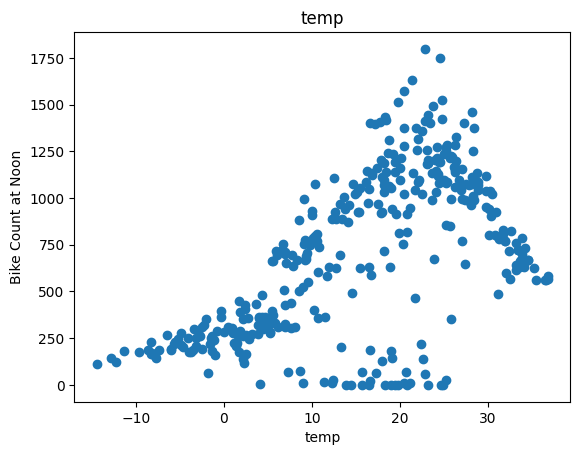

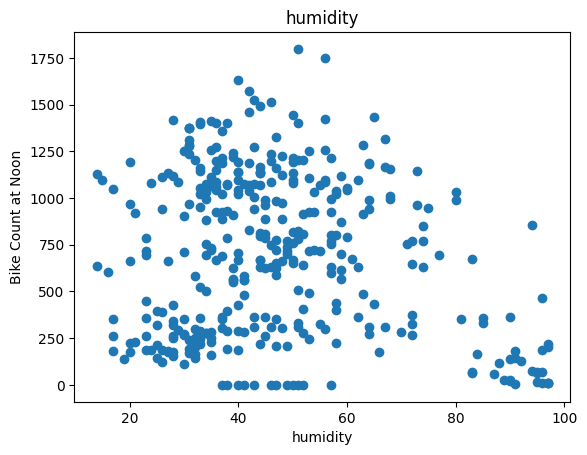

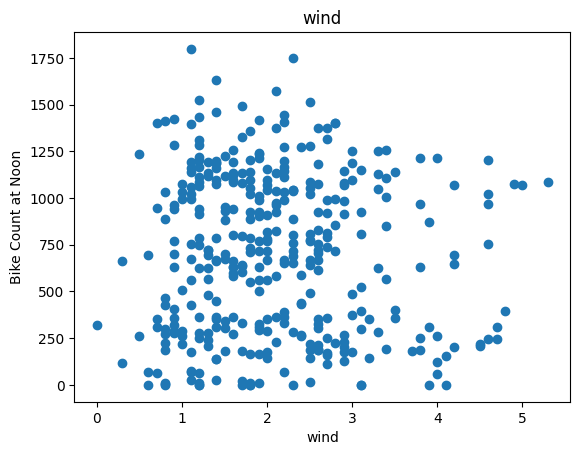

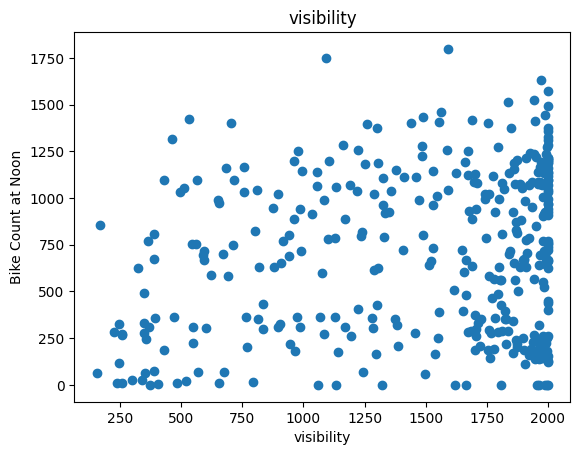

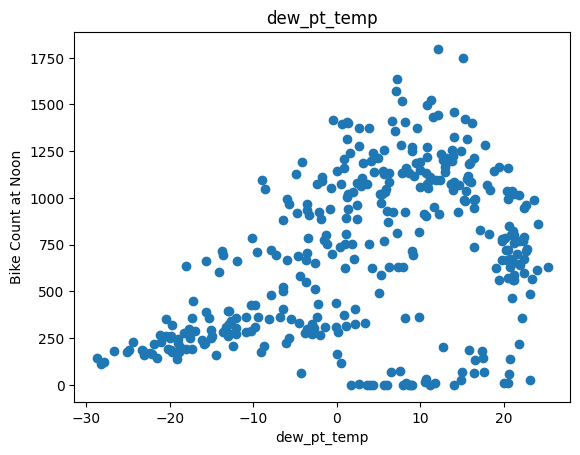

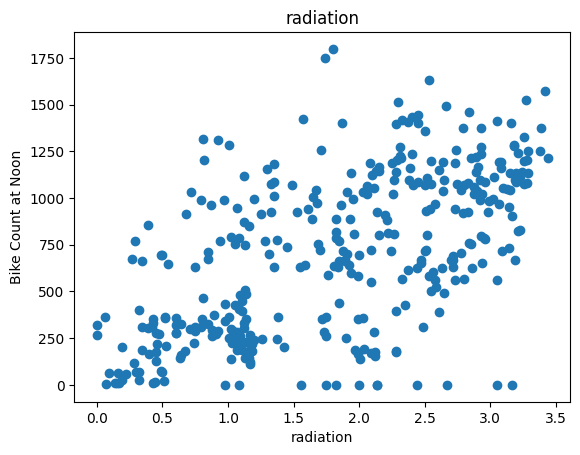

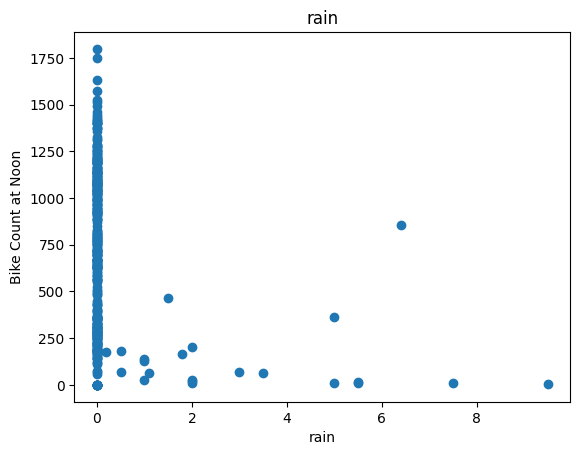

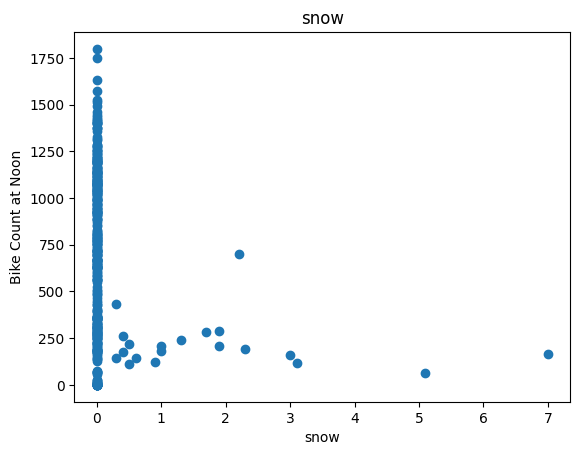

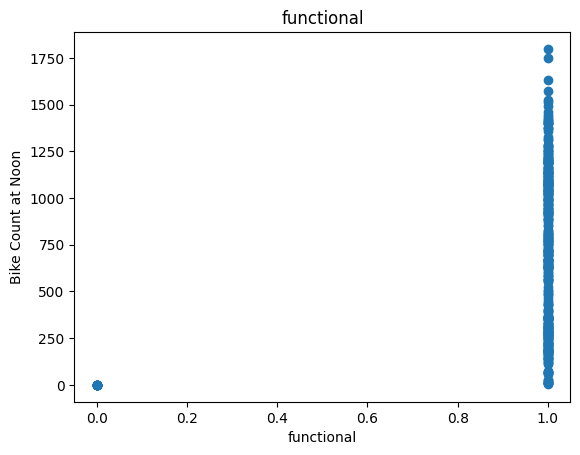

In [92]:
# start with features, which are the columns that are
# not bike count (which will be the dependent variable)
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

Above, we observe the following:
1. The `functional` variable does not give us any utility
2. The variables `snow` and `rain` do not give us any utility
3. The variable `radiation` appears to have a linear relationship
4. It appears that there is a fairly strong linear relationship between `bike_count` and `temperature`

Let's drop features from the dataset that we cannot use for the linear regression given that the relationship between these features and `bike_count` do not appear linear.

In [93]:
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Training, validation, and test data

Organize data for regression

In [94]:
# create training, validation, and test datasets
# split training at 60 percent and validation at 80 (20 percent)
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [95]:
# create a method to generate training data
def get_xy(dataframe, y_label, x_labels=None):
    """
    :param dataframe: input dataframe
    :param y_label: dependent variable
    :param x_labels: independent variable(s)
    :return: training data for X and y
    """
    # first create a deep copy to avoid
    dataframe = copy.deepcopy(dataframe)

    if x_labels is None:
        # return all independent variables from the dataframe
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        # dataframe needs to be reshaped for the given label
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        # otherwise, if there is a list of specific labels,
        # X is equal to the dataframe of those labels
        else:
            X = dataframe[x_labels].values

    # reshape in order to use hstack
    y = dataframe[y_label].values.reshape(-1, 1)

    # stack data horizontally using hstack
    data = np.hstack((X, y))

    return data, X, y


In [96]:
# let's try with one dimension first
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

## Simple linear regression

In [97]:
# create a regressor
temp_reg = LinearRegression()

# fit training data on regression model
temp_reg.fit(X_train_temp, y_train_temp)

# check regression coefficient and y intercept
print(temp_reg.coef_, temp_reg.intercept_)

[[21.18308198]] [376.132811]


In [98]:
# check the r squared value
temp_reg.score(X_test_temp, y_test_temp)

0.39514213255872865

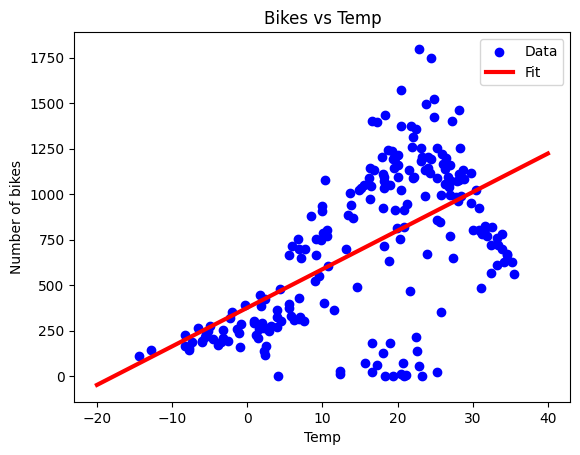

In [99]:
# plot to see how this looks
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

Above, we see a line of best fit. But it's not clear whether all of the necessary assumptions of linear regressions are satisfied (see bottom of scatter plot, for example). However, this is just an example. We can move onto a multile linear regression.

## Multiple linear regression

We can include a collection of features to observe a multiple linear regression.

In [100]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [101]:
# let's try with many features
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [102]:
# create a regression model
all_reg = LinearRegression()

# fit the model
all_reg.fit(X_train_all, y_train_all)

# get r squared value
# we see an increase relative to the
# single feature
all_reg.score(X_test_all, y_test_all)

0.40721976507192015

## Regression with Neural Networks

We can perform a linear regression using the Tensorflow package.

In [103]:
# first we want to retrieve a normalization layer
# typically, it helps to normalize a linear regression model
# we already have the data, we do not need to create it again
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)

# we want to adapt to X_train_temp
temp_normalizer.adapt(X_train_temp.reshape(-1))

Now that we have this normalized layer, we want to pass it into a Sequential model. Below we see the following when creating a regression model using a single node:
1. There is a single dense layer where a single node means that the model is linear
2. We pass the normalizer in directly

In [104]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

# we can now compile and pass in an optimizer
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

# fit the model and retrieve the model history
history = temp_nn_model.fit(
    X_train_temp.reshape(-1),
    y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_temp, y_valid_temp)
)

In [105]:
# create a method for plotting model history
def plot_loss(history):
    """
    Plots validation loss of model
    :param history: model history
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

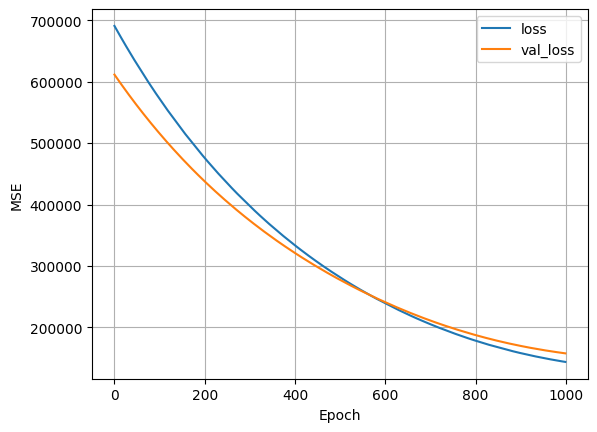

In [106]:
plot_loss(history)

Above, we see the loss and validation loss values converging. We can also run a plot similar to the one under the simple linear regression section to observe the regression line. Below, we see that the fit does not entirely match the one above but still displays a linear relationship.

The reason for the discrepancy is the training process when using the neural network approach:
1. Neural net uses back propagation
2. Linear regression without a neural net likely computes the line of best fit rather than using a neural net

4/4 [==============================] - 0s 2ms/step


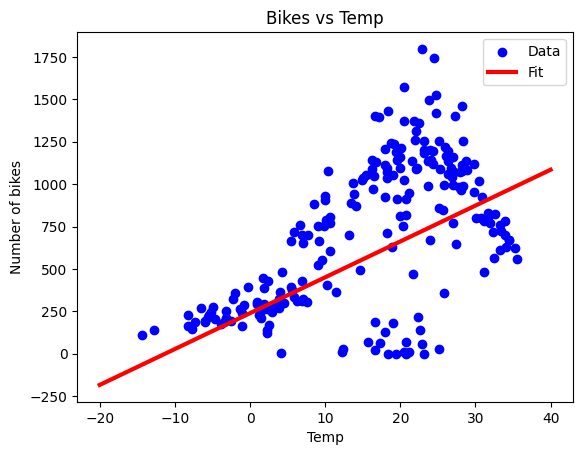

In [107]:
# plot to see how this looks using a neural net
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

What about a real neural net rather than a single node? We can get started by using the same normalizer. However, we no longer want to use a single dense layer and instead set the layer equal to 32 units and use ReLU activation (duplicate this layer). Don't forget the single node for the output layer.

In [108]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

# we can now compile and pass in an optimizer
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# fit the model and retrieve the model history
history = nn_model.fit(
    X_train_temp,
    y_train_temp,
    verbose=0,
    epochs=100,
    validation_data=(X_valid_temp, y_valid_temp)
)

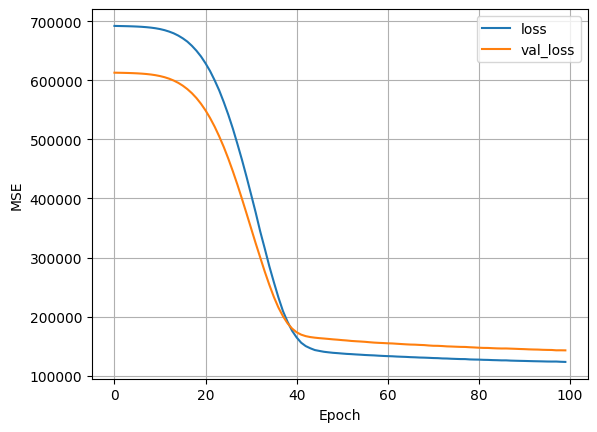

In [109]:
plot_loss(history)

Interestingly, we see losses converging again. What happens when we plot the data and regression line again?

4/4 [==============================] - 0s 2ms/step


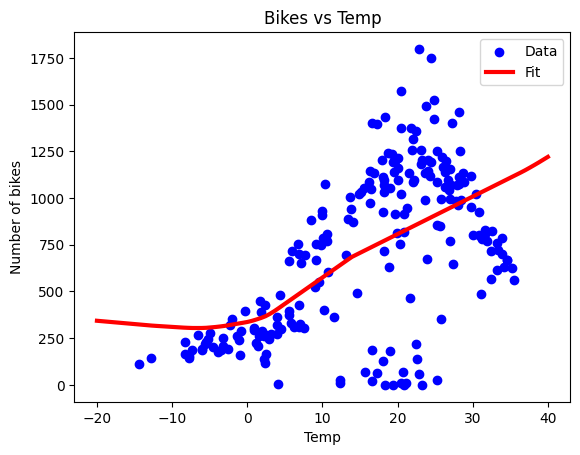

In [110]:
# plot to see how this looks using a neural net
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

We observe a curve, which tells us that this may not necessarily be the best model. We see that this is no longer a linear predictor but we do see that there is a predicted value.

We can try this again with multiple features. Remember that you will need to change your normalizer.

In [111]:
# create a new normalizer
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

In [112]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# we can now compile and pass in an optimizer
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# fit the model and retrieve the model history
history = nn_model.fit(
    X_train_all,
    y_train_all,
    verbose=0,
    epochs=100,
    validation_data=(X_valid_all, y_valid_all)
)

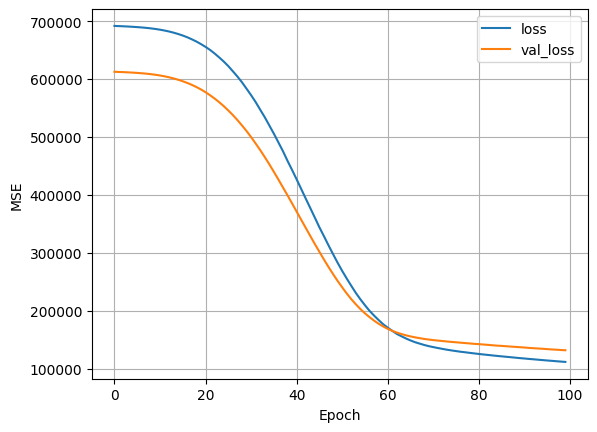

In [113]:
plot_loss(history)

In [114]:
# calculate MSE for both lienar reg and neural net
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 3ms/step


In [115]:
def mse(y_pred, y_real):
    """
    Calculate the mean squared error
    :param y_pred: predicted y values
    :param y_real: real dataset y values
    :return: mse value
    """
    return (np.square(y_pred - y_real)).mean()

In [116]:
mse(y_pred_lr, y_test_all)

98466.95085682461

In [117]:
mse(y_pred_nn, y_test_all)

107232.61325786312

Above, we see that the MSE using a neural network is larger than the linear regressor. We can plot the real results versus the predicted values to explore this further.

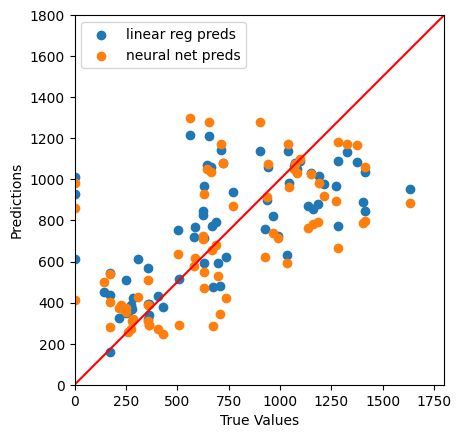

In [118]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label="linear reg preds")
plt.scatter(y_test_all, y_pred_nn, label="neural net preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()

_ = plt.plot(lims, lims, c="red")

It appears that we neural net predictions are more spread out and there are some values that are under-predicted as the true value of bike counts increases.